<a href="https://colab.research.google.com/github/drc10723/GAN_design/blob/master/GAN_implementations/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generative Adversarial Networks

Aim of this notebook is to implement [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) paper by Ian Goodfellow. 

GAN models are trained to generate new images/content. Two models are trained parallel using adversarial training process.  A generative model G, which try to generate new images and a discriminator model D, which estimates probability of sample coming from training data rather than G.


### Let's start by imports


In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
# use cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available()
                      else "cpu")
print(f"Using {DEVICE} backend")

# batch size for training models 
# Change multiple of 16 only, else modify below code
BATCH_SIZE = 128 #@param {type:"integer"}

Using cuda backend


## Data Loading

We will use MNIST dataset available as part of torchvision module.

In [0]:
# convert images to tensors and normalize
# after normalization images will be in range [-1, 1] with mean zero.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                               ])
# download and load training set of MNIST
mnist = datasets.MNIST("./mnist", train=True, download=True, transform = transform)
# create generator data loader with given batch size
dataloader = torch.utils.data.DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

In [0]:
# for checking data, lets create iterator
# We won't use this iterator for training purpose
dataiter = iter(dataloader)
images, labels = next(dataiter)
# Create images grid of 16 rows, batch size need to be multiple of 16
# for batch size of 128, 128 images will be arranged in 8*16 grid 
torchvision.utils.save_image(images, "MNIST_input_grid.jpg", nrow=16, padding=0, normalize=False)

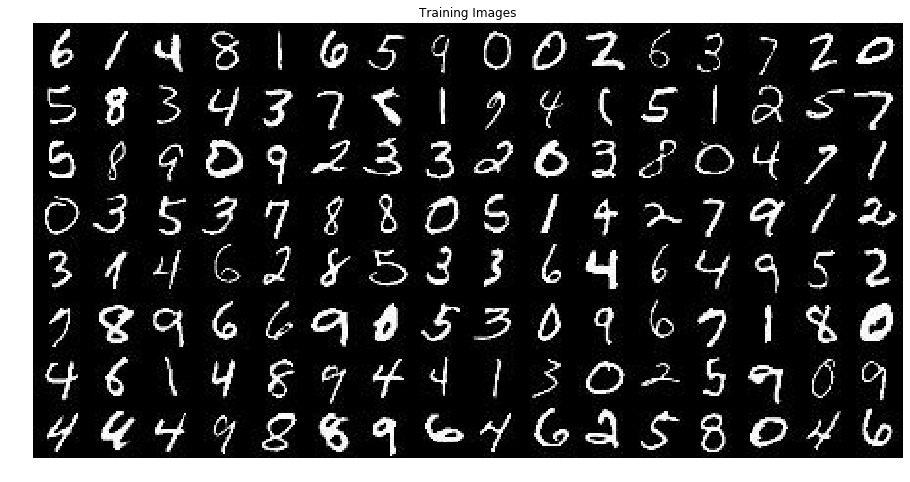

In [6]:
# Load saved training images grid and visualize using matplotlib
# Figure of size 16*(Batch_size/16)
plt.figure(figsize=(16, BATCH_SIZE/16))
plt.axis("off")
plt.title("Training Images")
# using _ for avoiding extra outputs
_ = plt.imshow(Image.open("MNIST_input_grid.jpg"))

## Discriminator Model ( D )

Discriminator is a binary classification model, which predicts if given image is generated one or taken from training data.

Original paper implementation uses maxout and dropout for training discriminator. We will use Linear layers with Leaky ReLU and dropout only. 

In [0]:
class Discriminator(nn.Module):
  """ D(x) """
  def __init__(self):
    # initalize super module
    super(Discriminator, self).__init__()
    # create a sequential layer with Linear layers
    # we are not using CNN layers here for keeping it simple
    # as mentioned in paper a fully connected with enough parameters should be sufficient
    # layer will have input of size : (batch_size, 784)
    self.layer = nn.Sequential(nn.Linear(784, 512),
                               # size : (batch_size, 512)
                               nn.LeakyReLU(0.2),
                               # Dropout layer
                               nn.Dropout(0.4),
                               # size : (batch_size, 512)
                               nn.Linear(512, 256),
                               # size : (batch_size, 256)
                               nn.LeakyReLU(0.2),
                               # Dropout layer
                               nn.Dropout(0.4),
                               # size : (batch_size, 256)
                               nn.Linear(256, 1),
                               # size : (batch_size, 1)
                               # sigmoid layer to convert in [0,1] range
                               nn.Sigmoid()
                               )
  
  def forward(self, x):
    # size of x : (batch_size, 1, 28, 28)
    x = x.view(x.shape[0], -1)
    # size of x : (batch_size, 784)
    x = self.layer(x)
    # size of x : (batch_size, 1)
    return x

In [8]:
# Create the Discriminator
D = Discriminator().to(DEVICE)
print(D)

Discriminator(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.4)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.4)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


## Generator Model ( G )

Aim of the generator is to fool the discriminator model.


For stable trainining of Generator model

*   Using batchnorm in  the generator

*   Using LeakyReLU activation in the discriminator
*   Last layer of the generator is tanh

[DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) provides some guidelines on stabilizing GAN models






In [0]:
class Generator(nn.Module):
  """ G(z) """
  def __init__(self, input_size=100):
    # initalize super module
    super(Generator, self).__init__()
    # layer will have input of size : (batch_size, 100)
    self.layer = nn.Sequential(nn.Linear(input_size, 128),
                               # size : (batch_size, 128)
                               nn.BatchNorm1d(128),
                               # size : (batch_size, 128)
                               nn.ReLU(),
                               # size : (batch_size, 128)
                               nn.Linear(128, 256),
                               # size : (batch_size, 256)
                               nn.BatchNorm1d(256),
                               # size : (batch_size, 256)
                               nn.ReLU(),
                               # size : (batch_size, 256)
                               nn.Linear(256, 512),
                               # size : (batch_size, 512)
                               nn.BatchNorm1d(512),
                               # size : (batch_size, 512)
                               nn.ReLU(),
                               # size : (batch_size, 512)
                               nn.Linear(512, 1024),
                               # size : (batch_size, 1024)
                               nn.BatchNorm1d(1024),
                               # size : (batch_size, 1024)
                               nn.ReLU(),
                               # size : (batch_size, 1024)
                               nn.Linear(1024, 784),
                               # size : (batch_size, 784)
                               nn.Tanh())
                               # size : (batch_size, 784)
    
  def forward(self, x):
    # size : (batch_size, 100)
    x = self.layer(x)
    # size : (batch_size, 784)
    x = x.view(x.shape[0], 1, 28, 28)
    # size : (batch_size, 1, 28, 28)
    return x

In [10]:
# Create the Generator
G = Generator().to(DEVICE)
print(G)

Generator(
  (layer): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=784, bias=True)
    (13): Tanh()
  )
)


## Model Training

Value of beta1 in Adam optimizer has huge impact on stability of generator and [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) recommend 0.5 value.

We can get far better results by using Ksteps more than 1, but you will need to train for more epochs. 

In [0]:
# number of training epochs
NUM_EPOCH = 50 #@param {type:"integer"}
# size of latent vector z
size_z = 100
# number of discriminator steps for each generator step
Ksteps = 2 #@param {type:"integer"}
# learning rate of adam
# DCGAN recommend 0.0002 lr
Adam_lr = 0.0002 #@param {type:"number"}
# DCGAN recommend 0.5
Adam_beta1 = 0.5 #@param {type:"number"}

In [0]:
# We calculate Binary cross entropy loss
criterion = nn.BCELoss()
# Adam optimizer for generator 
optimizerG = torch.optim.Adam(G.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))
# Adam optimizer for discriminator 
optimizerD = torch.optim.Adam(D.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))

In [0]:
# labels for training images x for Discriminator training
labels_real = torch.ones((BATCH_SIZE, 1)).to(DEVICE)
# labels for generated images G(z) for Discriminator training
labels_fake = torch.zeros((BATCH_SIZE, 1)).to(DEVICE)

In [0]:
# List of values, which will be used for plotting purpose
D_losses = []
G_losses = []
Dx_values = []
DGz_values = []

# number of training steps done on discriminator 
step = 0
for epoch in range(NUM_EPOCH):
  epoch_D_losses = []
  epoch_G_losses = []
  epoch_Dx = []
  epoch_DGz = []
  # iterate through data loader generator object
  # we don't need real class labels for training, so will be ignored
  for images, _ in dataloader:
    step += 1
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # images will be send to gpu, if cuda available
    x = images.to(DEVICE)
    # forward pass D(x)
    x_preds = D(x)
    # calculate loss log(D(x))
    D_x_loss = criterion(x_preds, labels_real)
    
    # create latent vector z from normal distribution 
    z = torch.randn(BATCH_SIZE, size_z).to(DEVICE)
    # generate image
    fake_image = G(z)
    # calculate D(G(z)), fake or not
    z_preds = D(fake_image.detach())
    # loss log(1 - D(G(z)))
    D_z_loss = criterion(z_preds, labels_fake)
    
    # total loss = log(D(x)) + log(1 - D(G(z)))
    D_loss = D_x_loss + D_z_loss
    
    # save values for plots
    epoch_D_losses.append(D_loss.item())
    epoch_Dx.append(x_preds.mean().item())
    
    # zero accumalted grads
    D.zero_grad()
    # do backward pass
    D_loss.backward()
    # update discriminator model
    optimizerD.step()
    
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
        
    # if Ksteps of Discriminator training are done, update generator
    if step % Ksteps == 0:
      # As we done one step of discriminator, again calculate D(G(z))
      z_out = D(fake_image)
      # loss log(D(G(z)))
      G_loss = criterion(z_out, labels_real)
      # save values for plots
      epoch_DGz.append(z_out.mean().item())
      epoch_G_losses.append(G_loss)
      
      # zero accumalted grads
      G.zero_grad()
      # do backward pass
      G_loss.backward()
      # update generator model
      optimizerG.step()
  else:
    # calculate average value for one epoch
    D_losses.append(sum(epoch_D_losses)/len(epoch_D_losses))
    G_losses.append(sum(epoch_G_losses)/len(epoch_G_losses))
    Dx_values.append(sum(epoch_Dx)/len(epoch_Dx))
    DGz_values.append(sum(epoch_DGz)/len(epoch_DGz))
    
    print(f" Epoch {epoch+1}/{NUM_EPOCH} Discriminator Loss {D_losses[-1]:.3f} Generator Loss {G_losses[-1]:.3f}"
         + f" D(x) {Dx_values[-1]:.3f} D(G(x)) {DGz_values[-1]:.3f}")
    
    # Generating images after each epoch and saving
    # set generator to evaluation mode
    G.eval()
    with torch.no_grad():
      # generate z
      z_test = torch.randn(BATCH_SIZE, size_z).to(DEVICE)
      # forward pass of G and generated image
      fake_test = G(z_test).cpu()
      # save images in grid of 16 * batch_size/16
      torchvision.utils.save_image(fake_test, f"MNIST_epoch_{epoch+1}.jpg", nrow=16, padding=0, normalize=False)
    # set generator to training mode
    G.train()

## Results

After 50 epoch training, we are able to generate good quailty images. We can improve more by using DCGAN and hyperparameter tuning.

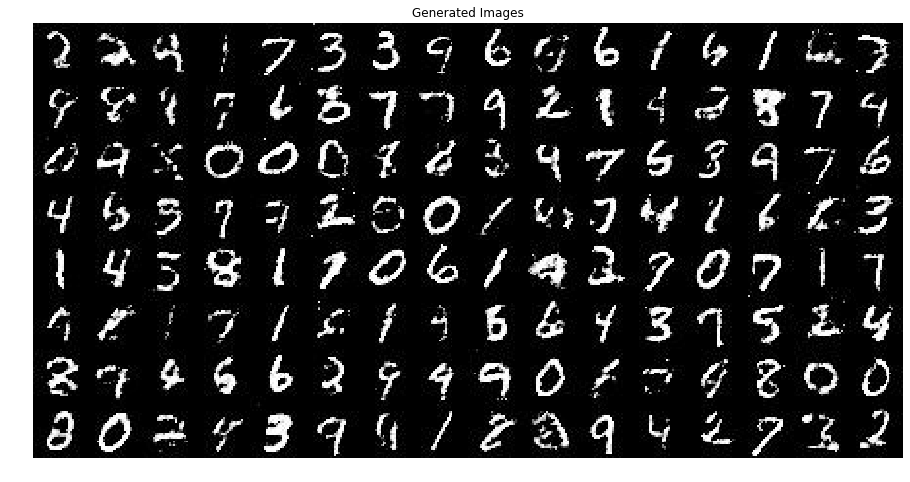

In [15]:
# Load saved generated images grid and visualize using matplotlib
# Figure of size 16*(Batch_size/16)
plt.figure(figsize=(16, BATCH_SIZE/16))
plt.axis("off")
plt.title("Generated Images")
# using _ for avoiding extra outputs
_ = plt.imshow(Image.open("MNIST_epoch_50.jpg"))

#### Plot for D(x) and D(G(z)) over the epochs
Ideally after long training, discriminator accuracy should go down to 0.5. Lets observe D(x) and D(G(z)) for all epochs.

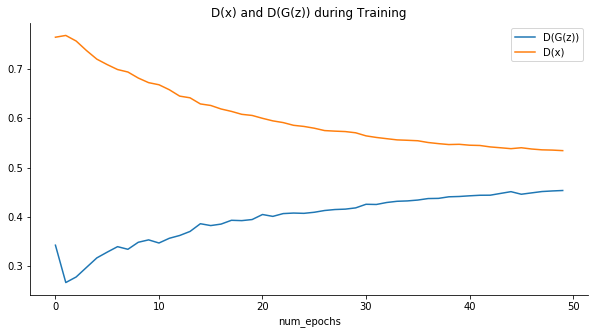

In [16]:
plt.figure(figsize=(10,5))
plt.title("D(x) and D(G(z)) during Training")
plt.plot(DGz_values,label="D(G(z))")
plt.plot(Dx_values,label="D(x)")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("num_epochs")
plt.legend()
plt.show()

As we can see values of both D(x) and D(G(x)) look like converging close to 0.5

#### Plot for Discriminator and Generator loss over the epochs

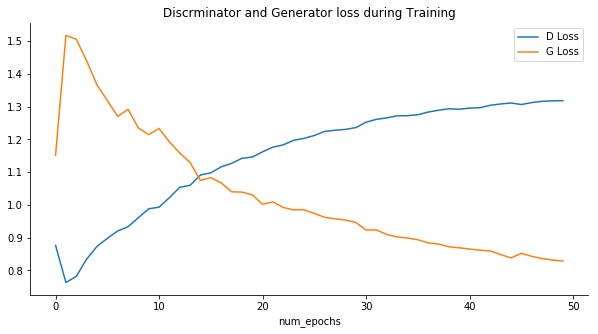

In [17]:
plt.figure(figsize=(10,5))
plt.title("Discrminator and Generator loss during Training")
plt.plot(D_losses,label="D Loss")
plt.plot(G_losses,label="G Loss")
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("num_epochs")
plt.legend()
plt.show()